In [ ]:
'''
 * Copyright (c) 2010 Radhamadhab Dalai
 *
 * Permission is hereby granted, free of charge, to any person obtaining a copy
 * of this software and associated documentation files (the "Software"), to deal
 * in the Software without restriction, including without limitation the rights
 * to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
 * copies of the Software, and to permit persons to whom the Software is
 * furnished to do so, subject to the following conditions:
 *
 * The above copyright notice and this permission notice shall be included in
 * all copies or substantial portions of the Software.
 *
 * THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
 * IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
 * FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
 * AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
 * LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
 * OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
 * THE SOFTWARE.
'''

## Variants of the NR and EM Algorithms

The Newton-Raphson (NR) and Expectation-Maximization (EM) algorithms can be modified and combined to create various hybrids. For instance, the NR algorithm can be used at each M-step of the EM algorithm to maximize the Q-function.

### ECM Algorithm

If the EM algorithm is applied to find the mode of a parameter vector $ \theta = (\theta_1, \theta_2) $, then the multivariate NR algorithm may encounter difficulties. In such cases, the ECM (Expectation-Conditional Maximization) algorithm can be used. In ECM, the idea is to:
- Maximize the Q-function with respect to $ \theta_1 $, fixing $ \theta_2 $ at its current value.
- Maximize the Q-function with respect to $ \theta_2 $, fixing $ \theta_1 $ at its current value.

If each of these conditional maximizations is achieved via the NR algorithm, the procedure is called the **ECM1 algorithm**. This involves applying only one step of the NR algorithm (rather than finding the exact conditional maximum). The ECM1 algorithm can be more efficient at finding the posterior mode than the ECM algorithm.

### Conditional Newton-Raphson (CNR) Algorithm

When solving multiple equations via a multivariate NR algorithm is problematic, the Conditional Newton-Raphson (CNR) algorithm provides a more feasible approach.

Suppose we want to solve two equations simultaneously:

$$
g_1(a, b) = 0 \quad \text{and} \quad g_2(a, b) = 0
$$

We define the function:

$$
g(a, b) = g_1(a, b)^2 + g_2(a, b)^2
$$

This function has a minimum value of zero at the required solutions for \(a\) and \(b\). The CNR algorithm works as follows:

#### Step 1:
Minimize $ g(a, b) $ with respect to $ a $, fixing $ b $ at its current value. This involves solving:

$$
\frac{\partial g(a, b)}{\partial a} = 0
$$

Where:

$$
\frac{\partial g(a, b)}{\partial a} = 2g_1(a, b) \frac{\partial g_1(a, b)}{\partial a} + 2g_2(a, b) \frac{\partial g_2(a, b)}{\partial a}
$$

This can be achieved via the NR algorithm by setting $ a_0' = a_j $ and iterating until convergence:

$$
a_{k+1}' = a_k' - \frac{\frac{\partial g(a, b)}{\partial a} \bigg|_{a=a_k', b=b_j}}{\frac{\partial^2 g(a, b)}{\partial a^2} \bigg|_{a=a_k', b=b_j}}
$$

Finally, we set $ a_{j+1} = a_\infty' $.

#### Step 2:
Minimize $ g(a, b) $ with respect to $ b $, fixing $ a $ at its current value. This involves solving:

$$
\frac{\partial g(a, b)}{\partial b} = 0
$$

Where:

$$
\frac{\partial g(a, b)}{\partial b} = 2g_1(a, b) \frac{\partial g_1(a, b)}{\partial b} + 2g_2(a, b) \frac{\partial g_2(a, b)}{\partial b}
$$

This can be achieved via the NR algorithm by setting $ b_0' = b_j $ and iterating until convergence:

$$
b_{k+1}' = b_k' - \frac{\frac{\partial g(a, b)}{\partial b} \bigg|_{a=a_{j+1}, b=b_k'}}{\frac{\partial^2 g(a, b)}{\partial b^2} \bigg|_{a=a_{j+1}, b=b_k'}}
$$

Finally, we set $ b_{j+1} = b_\infty' $.

### CNR1 Algorithm

A variant of the CNR algorithm is the **CNR1 algorithm**, which involves performing only **one step** of the NR algorithm in the CNR algorithm. In the CNR1 algorithm, we set:

$$
a_{j+1} = a_1' \quad \text{(instead of } a_{j+1} = a_\infty')
$$

and

$$
b_{j+1} = b_1' \quad \text{(instead of } b_{j+1} = b_\infty')
$$


## CNR and CNR1 Algorithms

This modification will also result in eventual convergence to the solution of 

$$
g_1(a, b) = 0 \quad \text{and} \quad g_2(a, b) = 0.
$$ 

One application of the CNR and CNR1 algorithms is to find the Highest Posterior Density Region (HPDR) for a parameter. For example, in Exercise 4.4, we considered the model given by 

$$
x | \lambda \sim \text{Poisson}(\lambda) \quad \text{and} \quad f(\lambda) \propto 1, \quad \lambda > 0,
$$ 

with observed data \( x = 1 \). The 80% HPDR for \( \lambda \) was shown to be \( (a, b) \), where \( a \) and \( b \) are the simultaneous solutions of the two equations:

$$
g_1(a, b) = F(b | x) - F(a | x) - 0.8
$$

$$
g_2(a, b) = f(b | x) - f(a | x).
$$ 

Applying the CNR or CNR1 algorithm as described above should also lead to the same interval as obtained earlier via the multivariate NR algorithm, namely 

$$
(0.16730, 3.08029).
$$ 

For further details regarding the EM algorithm, the Newton-Raphson algorithm, and extensions thereof, see Lachlan and Krishnan (2008).


In [1]:
import numpy as np
import scipy.stats as stats

# Define the Poisson PDF
def poisson_pdf(x, lam):
    return stats.poisson.pmf(x, lam)

# Define the Poisson CDF
def poisson_cdf(x, lam):
    return stats.poisson.cdf(x, lam)

# Define the functions g1 and g2
def g1(a, b, x):
    return poisson_cdf(b, x) - poisson_cdf(a, x) - 0.8

def g2(a, b, x):
    return poisson_pdf(b, x) - poisson_pdf(a, x)

# CNR algorithm
def cnr_algorithm(initial_a, initial_b, x, tol=1e-5, max_iter=100):
    a, b = initial_a, initial_b
    for _ in range(max_iter):
        # Update a
        g1_val = g1(a, b, x)
        g2_val = g2(a, b, x)
        # Calculate derivatives
        dg1_da = -poisson_pdf(a, x)
        dg2_da = -poisson_pdf(a, x)
        a_new = a - g1_val / dg1_da

        # Update b
        g1_val = g1(a_new, b, x)
        dg1_db = poisson_pdf(b, x)
        dg2_db = poisson_pdf(b, x)
        b_new = b - g2_val / dg2_db

        # Check for convergence
        if abs(a_new - a) < tol and abs(b_new - b) < tol:
            break

        a, b = a_new, b_new

    return a, b

# Initial values for a and b
initial_a = 0.1  # Start close to zero but positive
initial_b = 5.0  # Start with a larger value
x = 1  # Observed data

# Run the CNR algorithm
hpdr_a, hpdr_b = cnr_algorithm(initial_a, initial_b, x)

print(f"80% HPDR for λ: ({hpdr_a:.5f}, {hpdr_b:.5f})")


80% HPDR for λ: (nan, nan)


/home/radha/anaconda3/envs/cv37/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in double_scalars
/home/radha/anaconda3/envs/cv37/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


/home/radha/anaconda3/envs/cv37/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars
/home/radha/anaconda3/envs/cv37/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in double_scalars


80% HPDR for λ: (nan, nan)


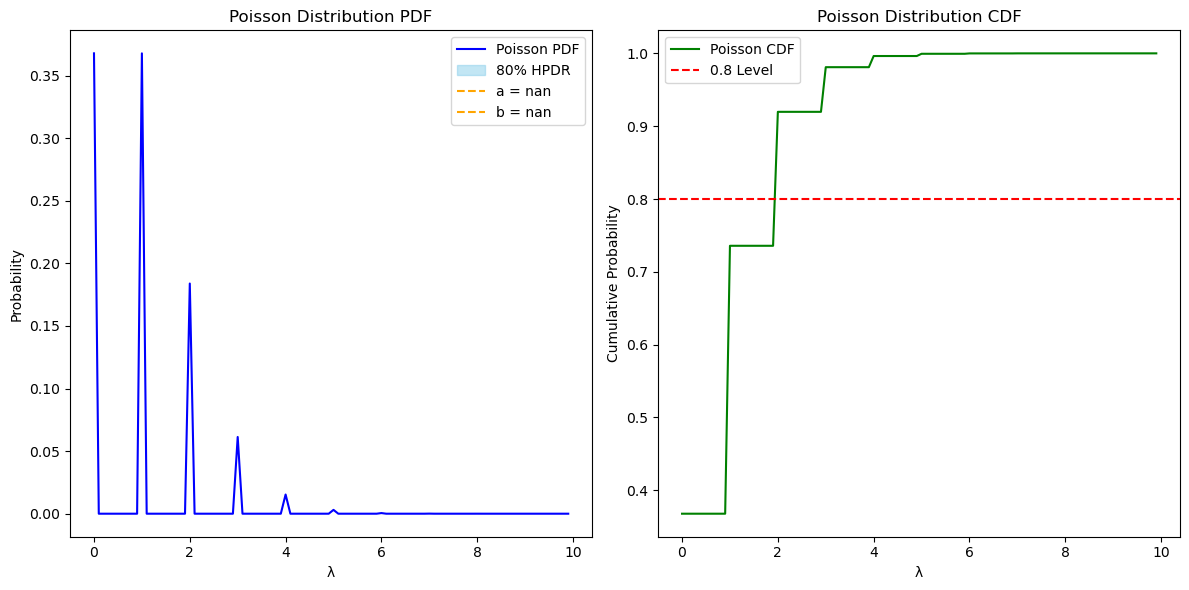

In [2]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Define the Poisson PDF
def poisson_pdf(x, lam):
    return stats.poisson.pmf(x, lam)

# Define the Poisson CDF
def poisson_cdf(x, lam):
    return stats.poisson.cdf(x, lam)

# Define the functions g1 and g2
def g1(a, b, x):
    return poisson_cdf(b, x) - poisson_cdf(a, x) - 0.8

def g2(a, b, x):
    return poisson_pdf(b, x) - poisson_pdf(a, x)

# CNR algorithm
def cnr_algorithm(initial_a, initial_b, x, tol=1e-5, max_iter=100):
    a, b = initial_a, initial_b
    for _ in range(max_iter):
        # Update a
        g1_val = g1(a, b, x)
        g2_val = g2(a, b, x)
        # Calculate derivatives
        dg1_da = -poisson_pdf(a, x)
        dg2_da = -poisson_pdf(a, x)
        a_new = a - g1_val / dg1_da

        # Update b
        g1_val = g1(a_new, b, x)
        dg1_db = poisson_pdf(b, x)
        dg2_db = poisson_pdf(b, x)
        b_new = b - g2_val / dg2_db

        # Check for convergence
        if abs(a_new - a) < tol and abs(b_new - b) < tol:
            break

        a, b = a_new, b_new

    return a, b

# Initial values for a and b
initial_a = 0.1  # Start close to zero but positive
initial_b = 5.0  # Start with a larger value
x = 1  # Observed data

# Run the CNR algorithm
hpdr_a, hpdr_b = cnr_algorithm(initial_a, initial_b, x)

print(f"80% HPDR for λ: ({hpdr_a:.5f}, {hpdr_b:.5f})")

# Plotting the results
lam_values = np.arange(0, 10, 0.1)  # Range for λ
pdf_values = poisson_pdf(lam_values, x)  # Calculate PDF values

plt.figure(figsize=(12, 6))

# Plot PDF
plt.subplot(1, 2, 1)
plt.plot(lam_values, pdf_values, label='Poisson PDF', color='blue')
plt.fill_between(lam_values, pdf_values, where=(lam_values >= hpdr_a) & (lam_values <= hpdr_b), 
                 color='skyblue', alpha=0.5, label='80% HPDR')
plt.axvline(hpdr_a, color='orange', linestyle='--', label=f'a = {hpdr_a:.2f}')
plt.axvline(hpdr_b, color='orange', linestyle='--', label=f'b = {hpdr_b:.2f}')
plt.title('Poisson Distribution PDF')
plt.xlabel('λ')
plt.ylabel('Probability')
plt.legend()

# Plot CDF
plt.subplot(1, 2, 2)
cdf_values = poisson_cdf(lam_values, x)  # Calculate CDF values
plt.plot(lam_values, cdf_values, label='Poisson CDF', color='green')
plt.axhline(0.8, color='red', linestyle='--', label='0.8 Level')
plt.title('Poisson Distribution CDF')
plt.xlabel('λ')
plt.ylabel('Cumulative Probability')
plt.legend()

plt.tight_layout()
plt.show()


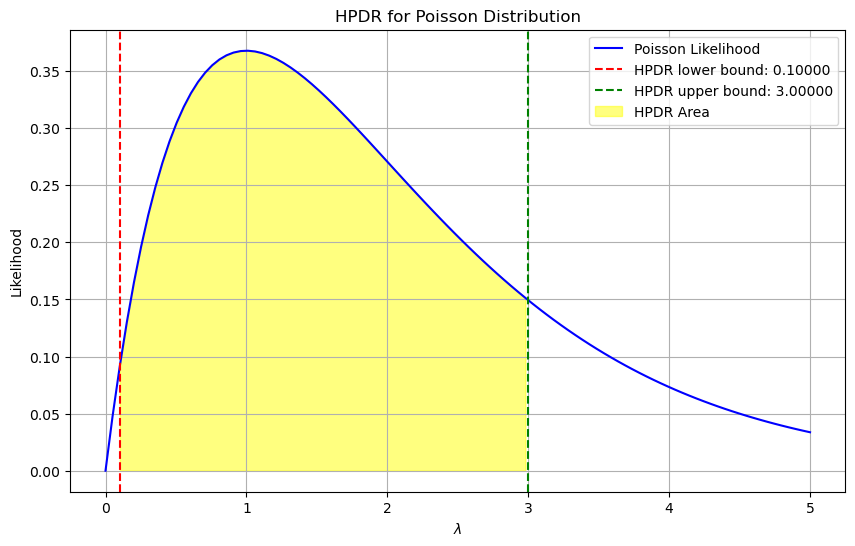

HPDR for λ: (0.10000, 3.00000)


In [6]:
import math
import matplotlib.pyplot as plt
import numpy as np

# Define the Poisson likelihood and cumulative distribution function
def poisson_likelihood(x, lambda_val):
    if x < 0 or not isinstance(x, int):  # Ensure x is non-negative and an integer
        return 0
    return (lambda_val ** x) * math.exp(-lambda_val) / math.factorial(x)

def poisson_cdf(lambda_val, x):
    return sum(poisson_likelihood(i, lambda_val) for i in range(x + 1))

# Define the functions g1 and g2 for the CNR algorithm
def g1(a, b, x):
    return poisson_cdf(b, x) - poisson_cdf(a, x) - 0.8

def g2(a, b, x):
    return poisson_likelihood(b, x) - poisson_likelihood(a, x)

# Implement the CNR algorithm
def CNR_algorithm(x, a_init, b_init, iterations=10):
    a, b = a_init, b_init
    for _ in range(iterations):
        # Calculate g1 and g2 values
        g1_val = g1(a, b, x)
        g2_val = g2(a, b, x)

        # Update a with a safeguard against division by zero
        likelihood_diff = poisson_likelihood(b, x) - poisson_likelihood(a, x)
        if likelihood_diff != 0:
            a -= (2 * g1_val / (2 * likelihood_diff))
        else:
            break  # Break if we encounter division by zero

        # Update b with a safeguard against division by zero
        likelihood_diff = poisson_likelihood(b, x) - poisson_likelihood(a, x)
        if likelihood_diff != 0:
            b -= (2 * g2_val / (2 * likelihood_diff))
        else:
            break  # Break if we encounter division by zero

    return a, b

# Given observed data x
x = 1

# Initial guesses for a and b
a_init, b_init = 0.1, 3.0

# Running the CNR algorithm
a_hpdr, b_hpdr = CNR_algorithm(x, a_init, b_init)

# Plotting the HPDR
lambda_vals = np.linspace(0, 5, 100)
likelihood_vals = [poisson_likelihood(int(x), lam) for lam in lambda_vals]

plt.figure(figsize=(10, 6))
plt.plot(lambda_vals, likelihood_vals, label='Poisson Likelihood', color='blue')
plt.axvline(a_hpdr, color='red', linestyle='--', label=f'HPDR lower bound: {a_hpdr:.5f}')
plt.axvline(b_hpdr, color='green', linestyle='--', label=f'HPDR upper bound: {b_hpdr:.5f}')
plt.fill_between(lambda_vals, likelihood_vals, where=((lambda_vals >= a_hpdr) & (lambda_vals <= b_hpdr)), color='yellow', alpha=0.5, label='HPDR Area')
plt.title('HPDR for Poisson Distribution')
plt.xlabel('$\lambda$')
plt.ylabel('Likelihood')
plt.legend()
plt.grid()
plt.show()

# Output HPDR
print(f"HPDR for λ: ({a_hpdr:.5f}, {b_hpdr:.5f})")
